In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erf
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', titlesize=20, labelsize=20)
plt.rc('legend', fontsize=14)
plt.rc('figure', titlesize=18)

#%matplotlib tk

In [106]:
def knife_edge_fit(x, x0, w, A, C):
    """
    Defines the error function model for a knife-edge scan of a Gaussian beam.
    See, for example, p. 17 of
    https://www.politesi.polimi.it/retrieve/b0b19da2-0788-434f-8313-4264bffda739/la%20tesina%20revised-converted.pdf
    I added a C offset because it wouldn't converge

    Parameters:
    x : array-like
        Position of the knife edge.
    x0 : float
        The center position of the beam.
    w : float
        The 1/e^2 radius of the Gaussian beam waist.
    A : float
        Amplitude of the curve.
    C : float
        Vertical offset of the curve.
    """
    return  A * (1 - erf(np.sqrt(2) * (x - x0) / w)) + C 

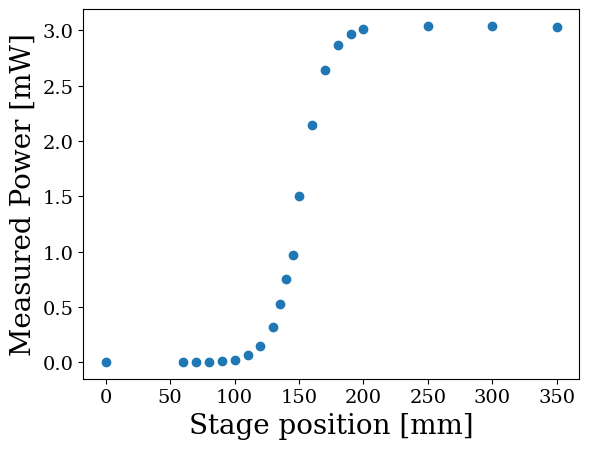

In [114]:
# --- Load Data ---
#pick one
file_path = 'knifeEdgeData_43p5in_multimodefiber_9_19_25.ods'
file_path = 'knifeEdgeData_6in_multimodefiber_9_19_25.ods'
#file_path = 'GaussianBeamData_v1_9_18_25.ods'
try:
    data = pd.read_excel(file_path, engine='odf')
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    print("Please make sure your CSV data file is in the same directory and named correctly.")
    # Create a dummy dataframe to avoid further errors if the file isn't found
    data = pd.DataFrame({'x': [0], 'y': [0]})


# --- Prepare Data for Fitting ---
# Get the column names automatically from the file
x_col_name      = data.columns[0]
y_col_name      = data.columns[1]

x_data          = data[x_col_name].to_numpy()
y_data          = data[y_col_name].to_numpy()

plt.figure()
plt.xlabel('Stage position [mm]')
plt.ylabel('Measured Power [mW]')
plt.scatter(x_data, y_data)

# Provide initial guesses for the fitting algorithm to help it converge
if 1: #auto guess
    x0_guess    = np.mean(x_data)
    w_guess     = (x_data.max() - x_data.min()) / 4
    A_guess     = (y_data.max() - y_data.min()) / 2
    C_guess     = y_data.min()

else:
    x0_guess    = 150
    w_guess     = 100
    A_guess     = 3
    C_guess     = 0


initial_guesses = [x0_guess, w_guess, A_guess, C_guess]

In [115]:
# --- Perform the Fit ---
try:
    popt, pcov = curve_fit(knife_edge_fit, x_data, y_data, p0=initial_guesses)
    
    # Unpack the optimal parameters
    x0_fit, w_fit, A_fit, C_fit = popt

    # --- Calculate Goodness of Fit (R-squared) ---
    residuals = y_data - knife_edge_fit(x_data, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_data - np.mean(y_data))**2)
    r_squared = 1 - (ss_res / ss_tot)

    # --- Print Results ---
    print("--- Beam Analysis Results ---")
    # Using abs() for beam waist as it should be a positive physical quantity
    print(f"1/e^2 Beam Radius (w): {abs(w_fit):.4f} {x_col_name.split('_')[-1]}") 
    print(f"Beam Center Position (x0): {x0_fit:.4f} {x_col_name.split('_')[-1]}")
    print(f"Amplitude (A): {abs(A_fit):.4f} mW") 
    print(f"Offset (c): {C_fit:.4f} mW")
    print(f"Goodness of Fit (R-squared): {r_squared:.6f}")
   

except (RuntimeError, ValueError) as e:
    print(f"Error during fitting: {e}")
    print("This can happen if initial guesses are too far off or the data is very noisy.")
    print("Try adjusting the 'initial_guesses' in the cell above.")
    # Set dummy values so the next cell doesn't error out
    popt = initial_guesses
    r_squared = 0

--- Beam Analysis Results ---
1/e^2 Beam Radius (w): 33.0633 thou
Beam Center Position (x0): 151.2719 thou
Amplitude (A): 1.5030 mW
Offset (c): 3.0236 mW
Goodness of Fit (R-squared): 0.999309


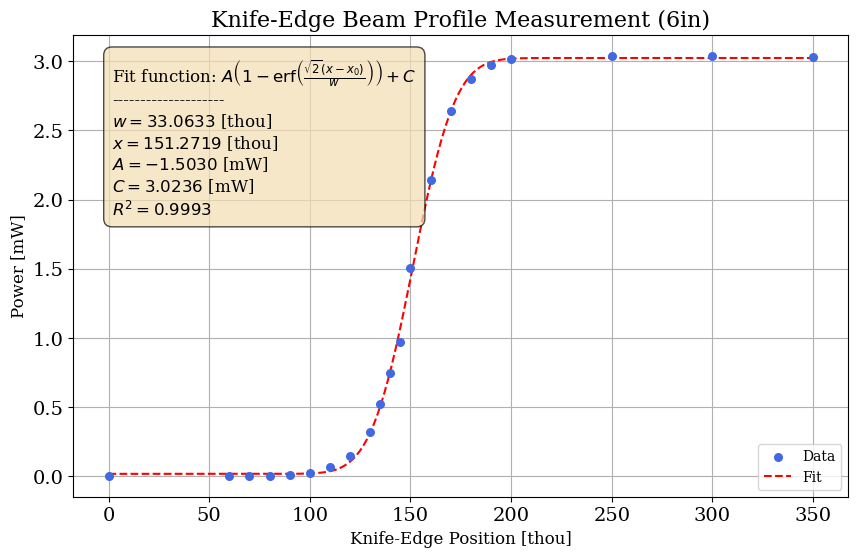

In [117]:
# --- Generate Data for Plotting the Fitted Curve ---
x_fit_curve = np.linspace(x_data.min(), x_data.max(), 200)
y_fit_curve = knife_edge_fit(x_fit_curve, *popt)

# --- Create the Plot ---
plt.figure(figsize=(10, 6))

# Plot the original experimental data
plt.scatter(x_data, y_data, label='Data', color='royalblue', s=30, zorder=5)

# Plot the fitted curve
plt.plot(x_fit_curve, y_fit_curve, label='Fit', color='red', linestyle='--')

# Add plot titles and labels
plt.title('Knife-Edge Beam Profile Measurement (6in)', fontsize=16)
plt.ylabel('Power [mW]', fontsize=12)
plt.xlabel("Knife-Edge Position [thou]", fontsize=12)
plt.legend(fontsize=10)

# Add an annotation with the results
beam_radius_text = f'Beam Radius (w) = {abs(popt[1]):.3f}'
r_squared_text = f'$R^2$ = {r_squared:.4f}'
info_text = (
        rf"Fit function: $ A \left( 1 - \text{{erf}}\left( \frac{{\sqrt{{2}}(x-x_0)}}{{w}} \right) \right) + C$"+'\n'+'--------------------\n'
        f"$w = {w_fit:.4f}$ [thou]\n" +
        f"$x = {x0_fit:.4f}$ [thou]\n" +
        f"$A = {A_fit:.4f}$ [mW]\n" +
        f"$C = {C_fit:.4f}$ [mW]\n" +
        f"$R^2 = {r_squared:.4f}$"
    )

    # --- Add the text box to the plot ---
plt.text(0.05, 0.95, info_text, 
             transform=plt.gca().transAxes, 
             fontsize=12,
             verticalalignment='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.7))
plt.grid()
plt.show()
